# <span id="top">Sentinel-1 Water Detection Comparisons</span>
This notebook will introduce two Synthetic Aperture Radar (SAR) thresholding techniques for detecting water. The first relies on the notion that land and water have very different but consistent responses from radar. The second relies on water being in the low quantiles of a SAR image's histogram. To test these methods' efficacy, we will also compare them to Landsat 8 water detection using Water Observations from Space (WOfS).

## Table of Contents

* [Configure Notebook](#conf)
    * [Import Dependencies and Connect to the Data Cube](#import)
    * [Define Functions](#functions)
    * [Choose Platforms and Products](#plat_prod)
    * [Create ODC instance](#instances)
    * [Extents](#extents)
        * [Get the Extents of the Cube](#cube_extents)
        * [Define the Extents of the Analysis](#dataset_extents)
            * [Visualize the selected areas](#visualize_area)
* [Load Data](#load)
    * [Load and Clean Data from the Data Cube](#load_data)
* [Calculate Products](#calculate)
    * [WOfS](#wofs)
* [Visualize Data](#visualize)
    * [Histogram Plots](#histogram_plots)
    * [Greyscale images](#grey_images)
    * [WOfS images](#wofs_images)
* [Thresholding](#thresholding)
    * [Automatic Thresholding](#auto_thresholding)
    * [Test Threshold as a Global Threshold](#global_thresholding)
    * [Discretization Method](#discretization)
* [Comparisons](#comparisons)
    * [Auto Threshold Comparison](#auto_comparisons)
    * [Global Threshold Comparison](#global_comparisons)
    * [Discretized Comparison](#discrete_comparisons)

## <span id="conf">Configure Notebook [&#9652;](#top)</span>
### <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import datacube
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from collections import namedtuple
from datetime import datetime

from matplotlib.colors import LinearSegmentedColormap

from skimage.filters import try_all_threshold, threshold_otsu, threshold_li, threshold_minimum, threshold_triangle
from sklearn.impute import SimpleImputer

from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_load import get_overlapping_area
from utils.data_cube_utilities.dc_time import dt_to_str
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.plotter_utils import figure_ratio, retrieve_or_create_fig_ax

# Set a legible font size for matplotlib plots.
plt.rcParams.update({'font.size': 16})

### <span id="functions">Define Functions [&#9652;](#top)</span>

In [2]:
month_names_long = ['January', 'February', 'March', 'April', 'May', 'June',
                    'July', 'August', 'September', 'October', 'November', 'December']

def n64_to_month_and_year(n64):
    datetime_val = datetime.utcfromtimestamp(n64.tolist() / 1e9)
    return month_names_long[datetime_val.month-1] + ' ' + str(datetime_val.year)

def match_time(ds, times):
    for time in times:
        if ''.join(time.split('-')) in ds.local_uri:
            return ds.id

def plot_threshold(ds, band_name, bottom = None , top = None, log_scaled = False, 
                   cmap_name = 'Greys', fig=None, ax=None):
    # Threshold is applied to original data, not log scaled data(if you haven't scaled already)
    _range = "Full {} range: {}-{}".format(band_name, ds[band_name].min().values,ds[band_name].max().values)

    selection = ds[band_name]
    
    my_cmap = cm.get_cmap(cmap_name)
    my_cmap.set_over('r')
    my_cmap.set_under('b')
    
    fig, ax = retrieve_or_create_fig_ax(fig, ax)
    
    selection = 10*np.log10(selection) if log_scaled == True else selection
    
    bottom    = 10*np.log10(bottom)    if log_scaled == True and bottom is not None else bottom
    top       = 10*np.log10(top)       if log_scaled == True and top is not None else top
    
    selection.plot(cmap = my_cmap, vmax =top, vmin = bottom, ax=ax)    
    xlim, ylim = ax.set_xlim(), ax.set_ylim()
    ax.text(min(xlim) + 0.5 * (max(xlim) - min(xlim)),
            min(ylim) + -0.1 * (max(ylim) - min(ylim)),_range, horizontalalignment = "center")

### <span id="instances">Create ODC instance [&#9652;](#top)</span>

In [3]:
# Create an instance of the datacube and API.
api = DataAccessApi(config="/home/localuser/.datacube.conf")
dc = api.dc

### <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

In [4]:
KWARGS = {'Sentinel-1': {'product': 's1monthly_gamma0_ghana',
                         'platform': 'SENTINEL1',
                         'measurements': ['vv', 'vh']},
          'Landsat 8': {'product': 'ls8_lasrc_ghana',
                        'platform': 'LANDSAT_8',
                        'measurements': ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']}
         }

### <span id="extents">Extents [&#9652;](#top)</span>
#### <span id="cube_extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [5]:
full_lat, full_lon, min_max_dates = get_overlapping_area(api,
                                                         list(map(lambda x: x[1]['platform'], KWARGS.items())),
                                                         list(map(lambda x: x[1]['product'], KWARGS.items())))

# Print the extents of each product.
str_min_max_dates = np.vectorize(dt_to_str)(min_max_dates)
for i, (platform, product) in enumerate(zip(list(map(lambda x: x[1]['platform'], KWARGS.items())),
                                            list(map(lambda x: x[1]['product'], KWARGS.items())))):
    print("For platform {} and product {}:".format(platform, product))
    print("Time Extents:", str_min_max_dates[i])
    print()

# Print the extents of the combined data.
min_start_date_mutual = np.max(min_max_dates[:,0])
max_end_date_mutual = np.min(min_max_dates[:,1])
print("Overlapping Extents:")
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, (min_start_date_mutual, max_end_date_mutual))))

For platform SENTINEL1 and product s1monthly_gamma0_ghana:
Time Extents: ['2015-03-15' '2018-10-15']

For platform LANDSAT_8 and product ls8_lasrc_ghana:
Time Extents: ['2013-04-13' '2019-02-16']

Overlapping Extents:
Latitude Extents: (4.690863952, 11.289762652)
Longitude Extents: (-3.36674818, 1.3938536199999998)
Time Extents: ['2015-03-15', '2018-10-15']


#### <span id="dataset_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [6]:
# Specify latitude and longitude bounds of an interesting area within the full extents.
# shown in the metadata report above (reduce area for faster processing times).

# Water Demo for Mining
# lat = (6.2407, 6.2444)
# lon = (-1.9025, -1.8993)

# Barekese Dam - We will retrieve our global threshold here.
train_lat = (6.82, 6.87)
train_lon = (-1.73, -1.68)

# Okosombo - Volta River 
# lat = (6.2546, 6.3226)
# lon = (0.0271, 0.0975)

# Volta Region Mangroves
# lat = (5.7666, 5.9425)
# lon = (0.5546, 0.8175)

# Densu Delta Ramsar Site
# lat = (5.505, 5.572)
# lon = (-0.330, -0.268)

# Stone Quarry with small water body.
# This area breaks auto-thresholding,
# but lends itself as a good test.
# lat = (6.84, 6.87)
# lon = (-1.75, -1.73)

# Landsat 8 & Sentinel-1 Same Scene
lat =  (6.10, 6.26) 
lon =  (-1.82, -1.660)

# lat = (6.1884,6.2298)
# lon = (-1.7093,-1.6655)

# Time Period
# Sentinel-1 data for Ghana is monthly and has a date tag of the 15th day in each month
# time_extents = ('2016-03-01', '2016-04-01')

time_extents = ('2014-01-01', '2019-01-01')
act_time_extents = ('2015-04-01', '2017-05-08', '2018-01-03')

##### <span id="visualize_area">Visualize the selected areas [&#9652;](#top)</span>
**The "Training" Area**

In [7]:
display_map(train_lat, train_lon)

**The Test Area**

In [8]:
display_map(lat, lon)

## <span id="load">Load Data [&#9652;](#top)</span>
### <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>

In [9]:
load_params = {'time': time_extents,
               'longitude': lon,
               'latitude': lat,
               'group_by': 'solar_day'}

Dataset = namedtuple('Dataset', 'kwargs data')
datasets = {}

search = dc.find_datasets(product=KWARGS['Landsat 8']['product'], longitude=lon, latitude=lat, time=time_extents)
ids = list(filter(lambda x: match_time(x, act_time_extents), search))

datasets['Sentinel-1'] = Dataset(kwargs={**KWARGS['Sentinel-1'], **load_params},
                                 data=dc.load(**{**KWARGS['Sentinel-1'], **load_params}))
datasets['Landsat 8'] = Dataset(kwargs={**KWARGS['Landsat 8'], **load_params},
                                data=dc.load(datasets=ids,
                                             like=datasets['Sentinel-1'].data,
                                             time=load_params['time'],
                                             group_by='solar_day',
                                             **KWARGS['Landsat 8']))

search = dc.find_datasets(product=KWARGS['Landsat 8']['product'],
                          longitude=train_lon,
                          latitude=train_lat,
                          time=time_extents)
ids = list(filter(lambda x: match_time(x, act_time_extents), search))

load_params.update(longitude=train_lon, latitude=train_lat)
datasets['Training'] = Dataset(kwargs={**KWARGS['Sentinel-1'], **load_params},
                               data=dc.load(**{**KWARGS['Sentinel-1'], **load_params}))
datasets['Training Landsat'] = Dataset(kwargs={**KWARGS['Landsat 8'], **load_params},
                                       data=dc.load(datasets=ids,
                                                    like=datasets['Training'].data,
                                                    time=load_params['time'],
                                                    group_by='solar_day',
                                                    **KWARGS['Landsat 8']))

In [10]:
for name, dataset in datasets.items():
    if name in ('Sentinel-1', 'Training'):
        dataset.data['clean_mask'] = ((dataset.data.vv != 0) | (dataset.data.vh != 0)).astype(np.uint8)
    if name in ('Landsat 8', 'Training Landsat'):
        dataset.data['clean_mask'] = landsat_qa_clean_mask(dataset.data, dataset.kwargs['platform'])

**Training Dataset**

In [11]:
sar_dataset = datasets['Training'].data.sel(time=list(map(lambda x: x.time.values,
                                                          filter(lambda x: x.sum() != 0,
                                                                 datasets['Training'].data.clean_mask))))
sar_dataset

<xarray.Dataset>
Dimensions:     (latitude: 278, longitude: 278, time: 43)
Coordinates:
  * time        (time) datetime64[ns] 2015-04-15 2015-05-15 ... 2018-10-15
  * latitude    (latitude) float64 6.87 6.87 6.87 6.869 ... 6.82 6.82 6.82 6.82
  * longitude   (longitude) float64 -1.73 -1.73 -1.73 ... -1.68 -1.68 -1.68
Data variables:
    vv          (time, latitude, longitude) float32 -6.9770536 ... -7.685915
    vh          (time, latitude, longitude) float32 -13.9482 ... -14.481129
    clean_mask  (time, latitude, longitude) uint8 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
Attributes:
    crs:      EPSG:4326

**Test Dataset**

In [12]:
test_datasets = datasets['Sentinel-1'].data.sel(time=list(map(lambda x: x.time.values,
                                                              filter(lambda x: x.sum() != 0,
                                                                     datasets['Sentinel-1'].data.clean_mask))))
test_datasets

<xarray.Dataset>
Dimensions:     (latitude: 887, longitude: 886, time: 44)
Coordinates:
  * time        (time) datetime64[ns] 2015-03-15 2015-04-15 ... 2018-10-15
  * latitude    (latitude) float64 6.26 6.26 6.26 6.26 ... 6.101 6.1 6.1 6.1
  * longitude   (longitude) float64 -1.82 -1.82 -1.82 ... -1.66 -1.66 -1.66
Data variables:
    vv          (time, latitude, longitude) float32 -7.9214473 ... -7.5613046
    vh          (time, latitude, longitude) float32 -10.933123 ... -12.8055105
    clean_mask  (time, latitude, longitude) uint8 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
Attributes:
    crs:      EPSG:4326

## <span id="calculate">Calculate Products [&#9652;](#top)</span>

### <span id="wofs">WOfS [&#9652;](#top)</span>

WOfS is an algorithm that classifies water using Landsat data. We will be using Landsat 8 data in this notebook.

In [13]:
train_wofs = wofs_classify(dataset_in=datasets['Training Landsat'].data)
wofs = wofs_classify(dataset_in=datasets['Landsat 8'].data)

## <span id="visualize">Visualize Data [&#9652;](#top)</span>

In [14]:
# Show acquisition indices and times.
print("Available acquisition indices and times")
times = sar_dataset.time.values
months = np.array(list(map(n64_to_month_and_year, times)))
pd.DataFrame(dict(times=times, months=months))

Available acquisition indices and times


,times,months
0,2015-04-15,April 2015
1,2015-05-15,May 2015
2,2015-06-15,June 2015
3,2015-07-15,July 2015
4,2015-08-15,August 2015
5,2015-09-15,September 2015
6,2015-10-15,October 2015
7,2015-11-15,November 2015
8,2015-12-15,December 2015
9,2016-01-15,January 2016


In [15]:
# Choose a single acquisition by its index (listed above)
acq_ind_to_show = 0

### <span id="histogram_plots">Histogram Plots [&#9652;](#top)</span>

In [16]:
from xarray.ufuncs import isfinite

# Determine a range of values to limit the x axis to for histogram plots.
# This allows the histograms to be more easily compared.
# Use quantiles to avoid extreme outliers.

# hist_ds = sar_dataset.isel(time=acq_ind_to_show)[['vv','vh','vvvh']]
hist_ds = sar_dataset.isel(time=acq_ind_to_show)[['vv','vh']]
hist_ds = hist_ds.where(isfinite(hist_ds))

min_per_data_var = hist_ds.quantile(0.001).to_array().values
min_val = min_per_data_var[np.isfinite(min_per_data_var)].min()

max_per_data_var = hist_ds.quantile(0.999).to_array().values
max_val = max_per_data_var[np.isfinite(max_per_data_var)].max()

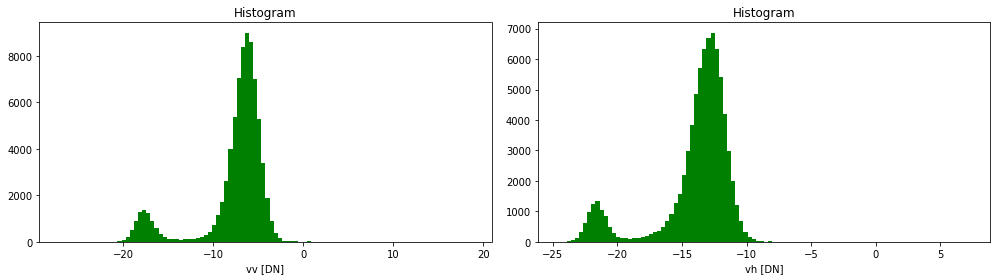

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

sar_dataset.isel(time=acq_ind_to_show).vv.plot.hist(ax=ax[0], bins=100, facecolor='green')
sar_dataset.isel(time=acq_ind_to_show).vh.plot.hist(ax=ax[1], bins=100, facecolor='green')

plt.tight_layout()
plt.show()

### <span id="grey_images">Greyscale images [&#9652;](#top)</span>

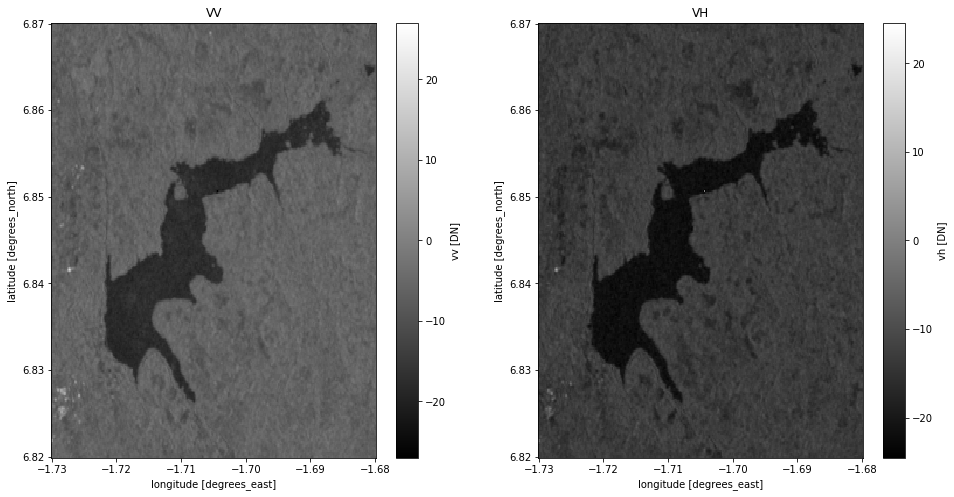

In [18]:
figsize = figure_ratio(sar_dataset.isel(time=acq_ind_to_show))
fig, ax = plt.subplots(1, 2, figsize=(figsize[0]*2, figsize[1]))
sar_dataset.isel(time=acq_ind_to_show).vv.plot.imshow(ax=ax[0], cmap=plt.cm.gray)
sar_dataset.isel(time=acq_ind_to_show).vh.plot.imshow(ax=ax[1], cmap=plt.cm.gray)
ax[0].set_title('VV')
ax[1].set_title('VH');

### <span id="wofs_images">WOfS images [&#9652;](#top)</span>

**Select Training Dataset Time**

Select time based on the highest number of clean pixels.

In [20]:
# Show acquisition indices and times.
print("Available acquisition indices and times")
train_times = datasets['Training Landsat'].data.time.values
months = np.array(list(map(n64_to_month_and_year, train_times)))
pd.DataFrame(dict(times=train_times, months=months))

Available acquisition indices and times


,times,months
0,2015-04-01 10:20:53,April 2015
1,2017-05-08 10:20:49,May 2017
2,2018-01-03 10:21:37,January 2018


In [21]:
# Select the wofs mask with the maximum number of clean pixels
mask_list = list(map(lambda x: x.sum(), datasets['Training Landsat'].data.clean_mask))
train_wofs_time = np.argmax(mask_list)
print('\033[1mSelected Time:\033[0m {time}'.format(time=train_times[train_wofs_time]))

Selected Time: 2015-04-01T10:20:53.000000000


In [22]:
# Can uncomment to choose a WOfS time index from the tables above.
# train_wofs_time = 0

**Select Testing Dataset Time**

Select time based on the highest number of clean pixels.

In [23]:
# Show acquisition indices and times.
print("Available acquisition indices and times")
times = datasets['Landsat 8'].data.time.values
months = np.array(list(map(n64_to_month_and_year, times)))
pd.DataFrame(dict(times=times, months=months))

Available acquisition indices and times


,times,months
0,2015-04-01 10:21:17,April 2015
1,2017-05-08 10:21:13,May 2017
2,2018-01-03 10:22:01,January 2018


In [24]:
# Select the wofs mask with the maximum number of clean pixels
mask_list = list(map(lambda x: x.sum(), datasets['Landsat 8'].data.clean_mask))
wofs_time = np.argmax(mask_list)
print('\033[1mSelected Time:\033[0m {time}'.format(time=times[wofs_time]))

Selected Time: 2018-01-03T10:22:01.000000000


In [25]:
# Can uncomment to choose a WOfS time index from the tables above.
# wofs_time = 0

**Print Images**

**Note:** The WOfS image may not be the best result. The image is picked based on the scene with the highest number of clean pixels, but this does not entirely mean the image is best suited for water detection. There may be haze or discoloration in the image that affects the WOfS classification.

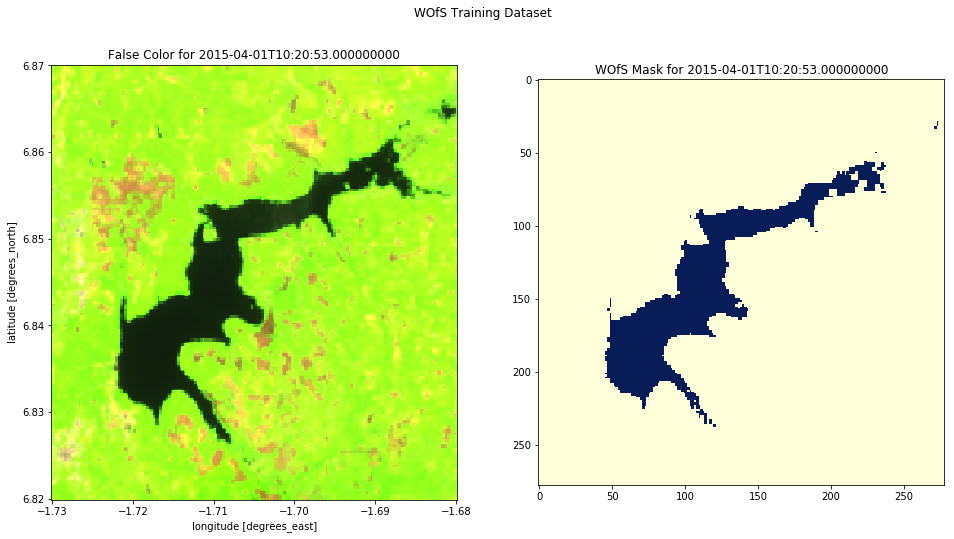

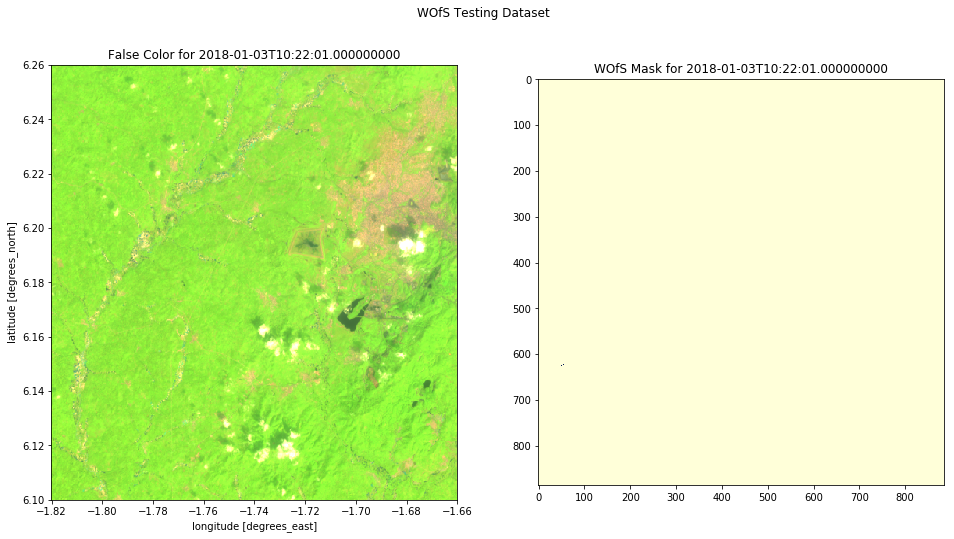

In [44]:
figsize_test = figure_ratio(wofs.isel(time=wofs_time))
figsize_train = figure_ratio(train_wofs.isel(time=wofs_time))

fig, ax = plt.subplots(1, 2, figsize=(figsize[0]*2, figsize[1]))
datasets['Training Landsat'].data.isel(time=train_wofs_time)[['swir1', 'nir', 'red']]\
    .to_array().plot.imshow(vmin=0, vmax=3000, ax=ax[0])
ax[1].imshow(train_wofs.isel(time=train_wofs_time).wofs, cmap=plt.cm.YlGnBu);
ax[0].set_title('False Color for {time}'.format(time=train_times[train_wofs_time]))
ax[1].set_title('WOfS Mask for {time}'.format(time=train_times[train_wofs_time]));
plt.suptitle('WOfS Training Dataset')

fig, ax = plt.subplots(1, 2, figsize=(figsize[0]*2, figsize[1]))
datasets['Landsat 8'].data.isel(time=wofs_time)[['swir1', 'nir', 'red']].to_array().plot.imshow(vmin=0,
                                                                                                vmax=3000,
                                                                                                ax=ax[0])
ax[1].imshow(wofs.isel(time=wofs_time).wofs, cmap=plt.cm.YlGnBu);
ax[0].set_title('False Color for {time}'.format(time=times[wofs_time]))
ax[1].set_title('WOfS Mask for {time}'.format(time=times[wofs_time]))
plt.suptitle('WOfS Testing Dataset');

## <span id="thresholding">Thresholding [&#9652;](#top)</span>

### <span id="auto_thresholding">Automatic Thresholding [&#9652;](#top)</span>

We can try using automated threshold algorithms to guess a threshold for us. However, this will only work if the histogram of the image appears binomial enough that some threshold can be determined which separates the distribution into two classifications. Automatic thresholding can sometimes become unreliable due to this requirement, the dataset in question, and the thresholding algorithm of choice. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) is the most well known and usually the most robust so it is the default choice.

**Note:** This can only work on a binomial distribution. That means it is best used for determining a threshold by analyzing an area with an even distribution of water and terrestrial areas. This threshold can then likely be used for other areas as a good starting point for the guess and check method.

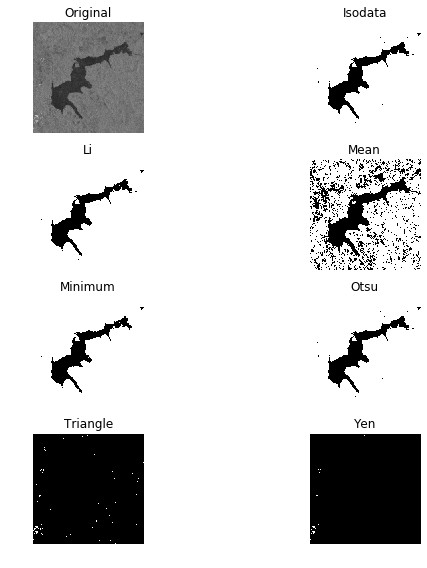

In [27]:
image_vv = sar_dataset.isel(time=acq_ind_to_show).vv.values
image_vh = sar_dataset.isel(time=acq_ind_to_show).vh.values

imp_mean = SimpleImputer3(missing_values=np.nan, strategy='mean')
image_vv = imp_mean.fit_transform(image_vv)
image_vh = imp_mean.fit_transform(image_vh)

fig, ax = try_all_threshold(image_vv, figsize=(10, 8), verbose=False)
plt.show()

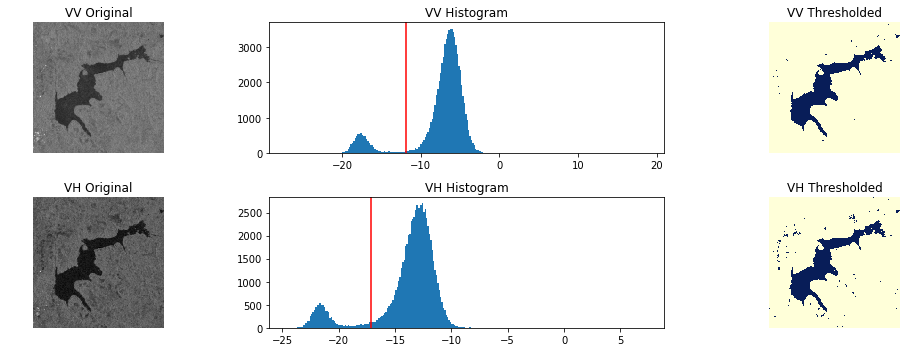

In [28]:
threshold_func = threshold_otsu

thresh_vv = threshold_func(image_vv)
thresh_vh = threshold_func(image_vh)

binary_vv = image_vv < thresh_vv
binary_vh = image_vh < thresh_vh

fig, ax = plt.subplots(2, 3, figsize=(16, 5))

ax[0][0].imshow(image_vv, cmap=plt.cm.gray)
ax[0][0].set_title('VV Original')
ax[0][0].axis('off')

ax[0][1].hist(image_vv.ravel(), bins=256)
ax[0][1].set_title('VV Histogram')
ax[0][1].axvline(thresh_vv, color='r')

ax[0][2].imshow(binary_vv, cmap=plt.cm.YlGnBu)
ax[0][2].set_title('VV Thresholded')
ax[0][2].axis('off')

ax[1][0].imshow(image_vh, cmap=plt.cm.gray)
ax[1][0].set_title('VH Original')
ax[1][0].axis('off')

ax[1][1].hist(image_vh.ravel(), bins=256)
ax[1][1].set_title('VH Histogram')
ax[1][1].axvline(thresh_vh, color='r')

ax[1][2].imshow(binary_vh, cmap=plt.cm.YlGnBu)
ax[1][2].set_title('VH Thresholded')
ax[1][2].axis('off')

plt.tight_layout()
plt.show()

In [29]:
print('\033[1mVV Threshold:\033[0m {}\n\033[1mVH Threshold:\033[0m {}'.format(thresh_vv, thresh_vh))

VV Threshold: -11.939693450927734
VH Threshold: -17.162921905517578


In [30]:
# Select the variable to plot: vv, vh, or vvvh

threshold_data_var = 'vv'

# Select the minimum and maximum values of the threshold range.
# Below the low limit = BLUE
# Above the high limit = RED

threshold_range = (thresh_vv, 5)

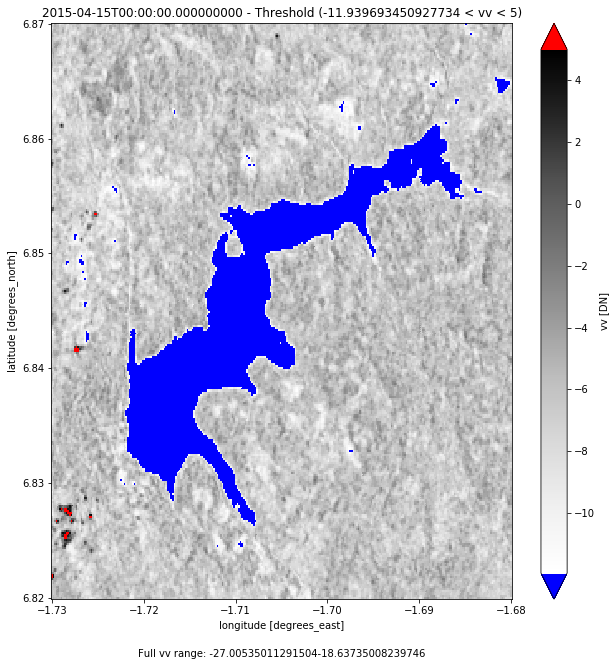

In [31]:
## Threshold Plot Settings ##

assert threshold_data_var in ['vv', 'vh', 'vvvh', 'vhvv'], \
    "The variable `threshold_data_var` must be one of 'vv', 'vh', 'vvvh', or 'vhvv'."

# Set the size of the figure.
figsize = figure_ratio(sar_dataset.isel(time=acq_ind_to_show))
## End Settings ##

# acq_data = sar_dataset.isel(time=acq_ind_to_show)
# if threshold_data_var == 'vvvh':
#     acq_data['vvvh'] = acq_data.vv / acq_data.vh
fig = plt.figure(figsize=figsize)
bottom, top = threshold_range
plot_threshold(sar_dataset.isel(time=acq_ind_to_show), 
               threshold_data_var, bottom=bottom, top=top, fig=fig)
plt.title(str(sar_dataset.isel(time=acq_ind_to_show).time.values) + 
          " - Threshold ({} < {} < {})".format(bottom, threshold_data_var, top))
plt.tight_layout()
plt.show();

### <span id="global_thresholding">Test Threshold as a Global Threshold [&#9652;](#top)</span>
We will test the threshold that was found in the previous section against another area. This method allows us to properly threshold even if the area does not have a binomial distribution. 

**Note:** This has limitations such that water does not give a consistent response between varying areas. It also suffers from false positives/negatives due to other varying terrain responses not being accounted for in the threshold.

In [32]:
image_test_vv = test_datasets.isel(time=acq_ind_to_show).vv.values
image_test_vh = test_datasets.isel(time=acq_ind_to_show).vh.values

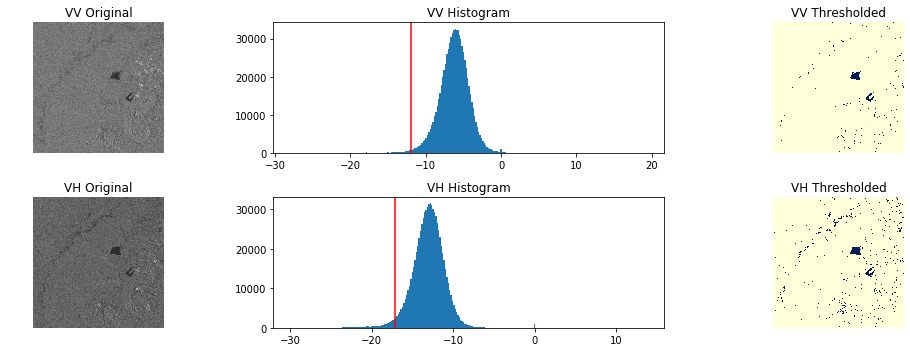

In [33]:
binary_test_vv = (image_test_vv < thresh_vv)
binary_test_vh = (image_test_vh < thresh_vh)

fig, ax = plt.subplots(2, 3, figsize=(16, 5))

ax[0][0].imshow(image_test_vv, cmap=plt.cm.gray)
ax[0][0].set_title('VV Original')
ax[0][0].axis('off')

ax[0][1].hist(image_test_vv.ravel(), bins=256)
ax[0][1].set_title('VV Histogram')
ax[0][1].axvline(thresh_vv, color='r')

ax[0][2].imshow(binary_test_vv, cmap=plt.cm.YlGnBu)
ax[0][2].set_title('VV Thresholded')
ax[0][2].axis('off')

ax[1][0].imshow(image_test_vh, cmap=plt.cm.gray)
ax[1][0].set_title('VH Original')
ax[1][0].axis('off')

ax[1][1].hist(image_test_vh.ravel(), bins=256)
ax[1][1].set_title('VH Histogram')
ax[1][1].axvline(thresh_vh, color='r')

ax[1][2].imshow(binary_test_vh, cmap=plt.cm.YlGnBu)
ax[1][2].set_title('VH Thresholded')
ax[1][2].axis('off')

plt.tight_layout()
plt.show()

In [34]:
# Select the variable to plot: vv, vh, or vvvh

threshold_data_var = 'vv'

# Select the minimum and maximum values of the threshold range.
# Below the low limit = BLUE
# Above the high limit = RED

threshold_range = (thresh_vv, 5)

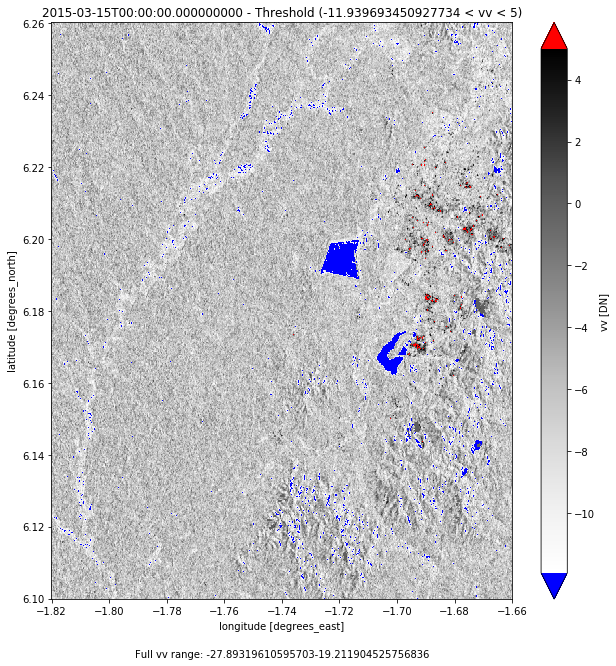

In [35]:
## Threshold Plot Settings ##

assert threshold_data_var in ['vv', 'vh', 'vvvh'], \
    "The variable `threshold_data_var` must be one of 'vv', 'vh', or 'vvvh'."

# Set the size of the figure.
figsize = figure_ratio(test_datasets.isel(time=acq_ind_to_show))
## End Settings ##

# acq_data = sar_dataset.isel(time=acq_ind_to_show)
# if threshold_data_var == 'vvvh':
#     acq_data['vvvh'] = acq_data.vv / acq_data.vh
fig = plt.figure(figsize=figsize)
bottom, top = threshold_range
plot_threshold(test_datasets.isel(time=acq_ind_to_show), 
               threshold_data_var, bottom=bottom, top=top, fig=fig)
plt.title(str(test_datasets.isel(time=acq_ind_to_show).time.values) + 
          " - Threshold ({} < {} < {})".format(bottom, threshold_data_var, top))
plt.show()

### <span id="discretization">Discretization Method [&#9652;](#top)</span>

This method will create discrete labels from the the image's histogram. This method assumes water will be in the lowest quantile of the histogram, and it allows for varying mask sizes based on manual interpretation and defining a quantile percentage.

**Note:** This method relies on there being a wide distribution of pixels and allows for a varying threshold sensitivity.

In [36]:
bins_vv = np.histogram(image_test_vv, bins='doane')
bins_vh = np.histogram(image_test_vh, bins='doane')

# bins_vv = np.sort(np.append(bins_vv, thresh_vv)) if bins_vv.min() >= thresh_vv else bins_vv
# bins_vh = np.sort(np.append(bins_vh, thresh_vh)) if bins_vh.min() >= thresh_vh else bins_vh

dig_vv = np.digitize(image_test_vv, bins_vv[1])
dig_vh = np.digitize(image_test_vh, bins_vh[1])

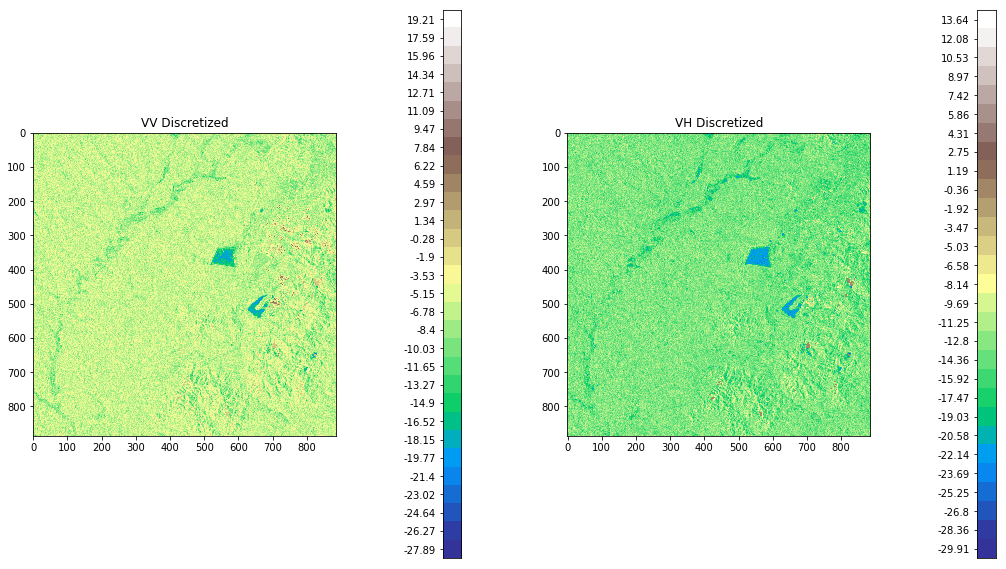

In [43]:
norm_vv = mpl.colors.Normalize(vmin=bins_vv[1].min().astype(np.int16), vmax=bins_vv[1].max().astype(np.int16))
norm_vh = mpl.colors.Normalize(vmin=bins_vh[1].min().astype(np.int16), vmax=bins_vh[1].max().astype(np.int16))

fig, ax = plt.subplots(1, 4, figsize=(figsize[0]*2, figsize[1]))
cmap = plt.cm.terrain

m_vv = plt.cm.ScalarMappable(norm=norm_vv, cmap=cmap)
m_vh = plt.cm.ScalarMappable(norm=norm_vh, cmap=cmap)

ax[0].imshow(dig_vv, cmap=cmap)
ax[0].set_title('VV Discretized');

ax[1].imshow(list(map(lambda x: [x], m_vv.to_rgba(bins_vv[1]))), origin='lower')
ax[1].set_yticks(np.arange(len(bins_vv[1])));
ax[1].set_yticklabels(list(map(lambda x: round(x, 2), bins_vv[1])));
ax[1].set_xticklabels('');
ax[1].xaxis.set_ticks_position('none');

ax[2].imshow(dig_vh, cmap=cmap)
ax[2].set_title('VH Discretized');

ax[3].imshow(list(map(lambda x: [x], m_vh.to_rgba(bins_vh[1]))), origin='lower')
ax[3].set_yticks(np.arange(len(bins_vh[1])));
ax[3].set_yticklabels(list(map(lambda x: round(x, 2), bins_vh[1])));
ax[3].set_xticklabels('');
ax[3].xaxis.set_ticks_position('none');

plt.tight_layout()

## <span id="comparisons">Comparisons [&#9652;](#top)</span>
We will compare all the previously shown results to get a better understanding of performance.

### <span id="auto_comparisons">Auto Threshold Comparisons [&#9652;](#top)</span>

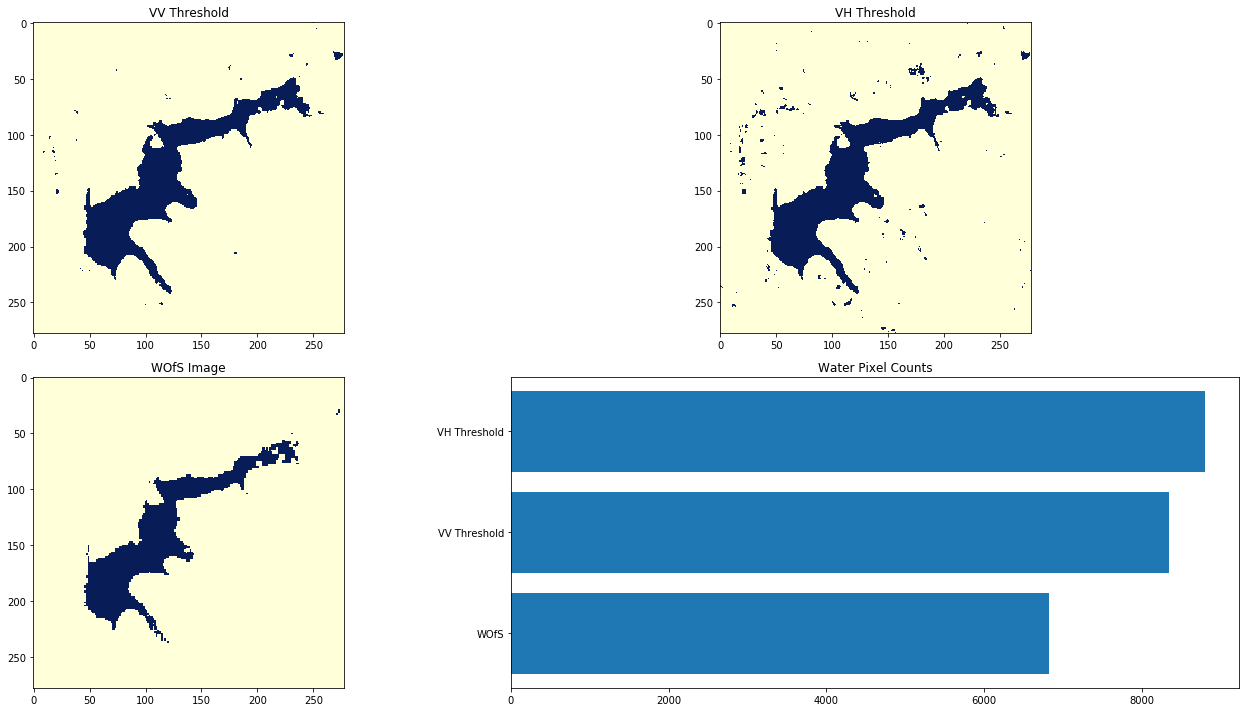

In [37]:
x = ('WOfS', 'VV Threshold', 'VH Threshold')
y = (train_wofs.isel(time=train_wofs_time).wofs.sum().item(), binary_vv.sum().item(), binary_vh.sum().item())

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0][0].imshow(binary_vv, cmap=plt.cm.YlGnBu)
ax[0][0].set_title('VV Threshold')
ax[0][1].imshow(binary_vh, cmap=plt.cm.YlGnBu)
ax[0][1].set_title('VH Threshold')
ax[1][0].imshow(train_wofs.isel(time=train_wofs_time).wofs, cmap=plt.cm.YlGnBu)
ax[1][0].set_title('WOfS Image')
ax[1][1].barh(x, y)
ax[1][1].set_title('Water Pixel Counts')

fig.tight_layout()

In [38]:
area_pct = tuple(map(lambda y: round((y/image_vv.size)*100, 2), y))
pd.DataFrame(dict(zip(x, zip(y, area_pct))), ['Pixel Count', 'Image Area %'])

,WOfS,VV Threshold,VH Threshold
Pixel Count,6828.00,8344.0,8800.00
Image Area %,8.83,10.8,11.39


### <span id="global_comparisons">Global Thresholding Comparisons [&#9652;](#top)</span>
We will compare all the previously shown results to get a better understanding of performance.

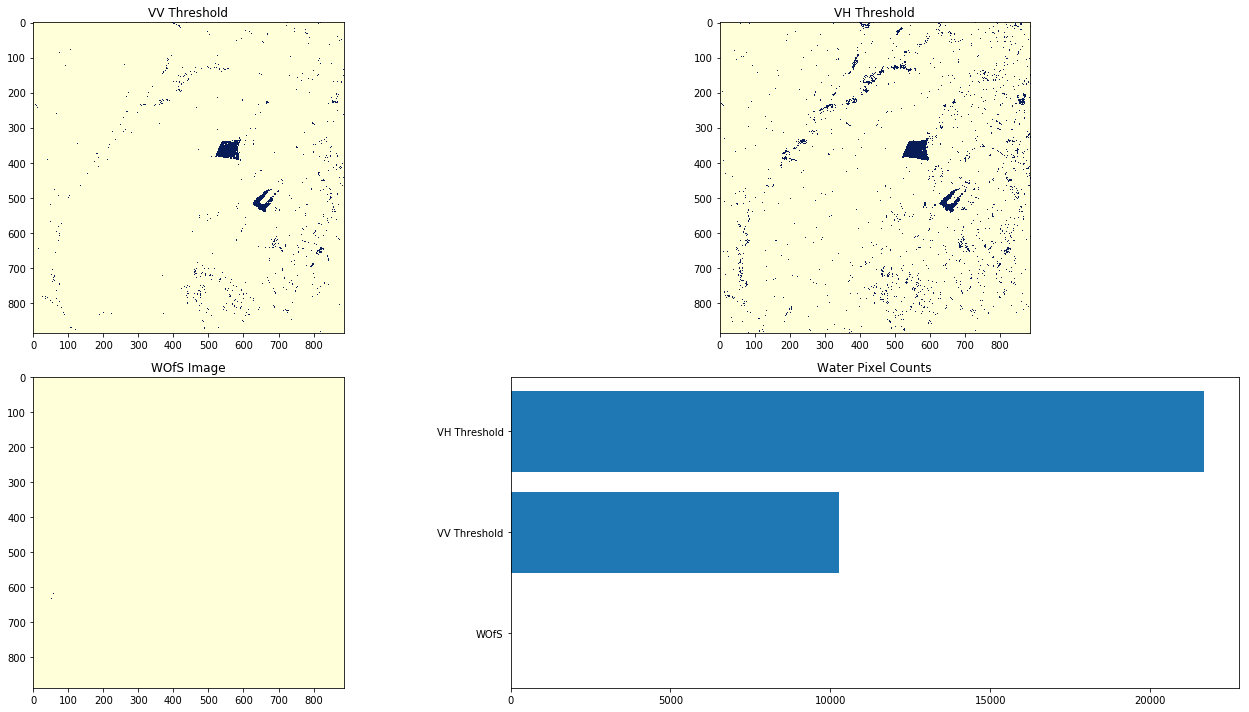

In [39]:
x = ('WOfS', 'VV Threshold', 'VH Threshold')
y = (wofs.isel(time=wofs_time).wofs.sum().item(), binary_test_vv.sum().item(), binary_test_vh.sum().item())

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0][0].imshow(binary_test_vv, cmap=plt.cm.YlGnBu)
ax[0][0].set_title('VV Threshold')
ax[0][1].imshow(binary_test_vh, cmap=plt.cm.YlGnBu)
ax[0][1].set_title('VH Threshold')
ax[1][0].imshow(wofs.isel(time=wofs_time).wofs, cmap=plt.cm.YlGnBu)
ax[1][0].set_title('WOfS Image')
ax[1][1].barh(x, y)
ax[1][1].set_title('Water Pixel Counts')

fig.tight_layout()

In [40]:
area_pct = tuple(map(lambda y: round((y/image_test_vv.size)*100, 2), y))
pd.DataFrame(dict(zip(x, zip(y, area_pct))), ['Pixel Count', 'Image Area %'])

,WOfS,VV Threshold,VH Threshold
Pixel Count,16.0,10269.00,21690.00
Image Area %,0.0,1.31,2.76


### <span id="discrete_comparisons">Discretized Comparisons [&#9652;](#top)</span>

We can now compare a selected quantile to WOfS.

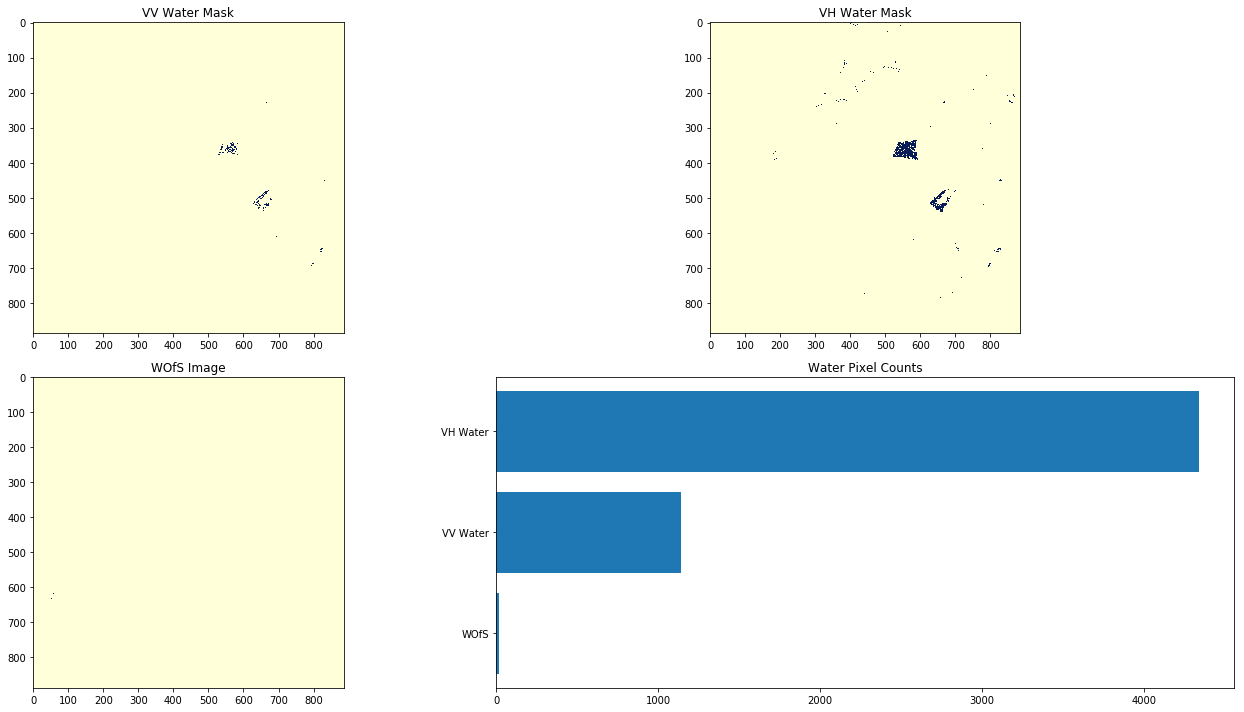

In [41]:
# Sets the quantile threshold for bins ex: quantile_pct = 0.2 
# only show the two lowest values from the plot above.
# Low value - low sensitivity
# High value - high sensitivity
quantile_pct = 0.2 # Select threshold using 20% quantile
bin_threshold_vv = (bins_vv[1] < np.quantile(bins_vv[1], quantile_pct)).sum()
bin_threshold_vh = (bins_vh[1] < np.quantile(bins_vh[1], quantile_pct)).sum() 

# Uncomment if you would like to manually select the layers to use.
# Ex: To pick the first two layers for VV set bin_threshold_vv = 2.
# bin_threshold_vv = 2
# bin_threshold_vh = 2

x = ('WOfS', 'VV Water', 'VH Water')
y = (wofs.isel(time=wofs_time).wofs.sum().item(),
     (dig_vv <= bin_threshold_vv).sum().item(),
     (dig_vh <= bin_threshold_vh).sum().item())

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0][0].imshow((dig_vv <= bin_threshold_vv), cmap=plt.cm.YlGnBu)
ax[0][0].set_title('VV Water Mask')
ax[0][1].imshow((dig_vh <= bin_threshold_vh), cmap=plt.cm.YlGnBu)
ax[0][1].set_title('VH Water Mask')
ax[1][0].imshow(wofs.isel(time=wofs_time).wofs, cmap=plt.cm.YlGnBu)
ax[1][0].set_title('WOfS Image')
ax[1][1].barh(x, y)
ax[1][1].set_title('Water Pixel Counts')

fig.tight_layout()

In [42]:
area_pct = tuple(map(lambda y: round((y/image_test_vv.size)*100, 2), y))
pd.DataFrame(dict(zip(x, zip(y, area_pct))), ['Pixel Count', 'Image Area %'])

,WOfS,VV Water,VH Water
Pixel Count,16.0,1143.00,4341.00
Image Area %,0.0,0.15,0.55
